In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.widgets as w
import glob
import meltInc.plotStyle as ps
import pandas as pd

ps.layout()

In [2]:
files_folder = "./glass"
files = [file for file in glob.glob(f"{files_folder}/*.txt")]


In [6]:
samples_interpolate = pd.DataFrame({"name": None, "interpolate": False, "left": 780, "right": 900}, index=np.arange(0, len(files)))

/var/folders/yw/9bnqhp0j5zschtqmcf10hcmw0000gn/T/ipykernel_51682/1047704638.py:20: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.subplots_adjust(left=0.25, bottom=0.25)


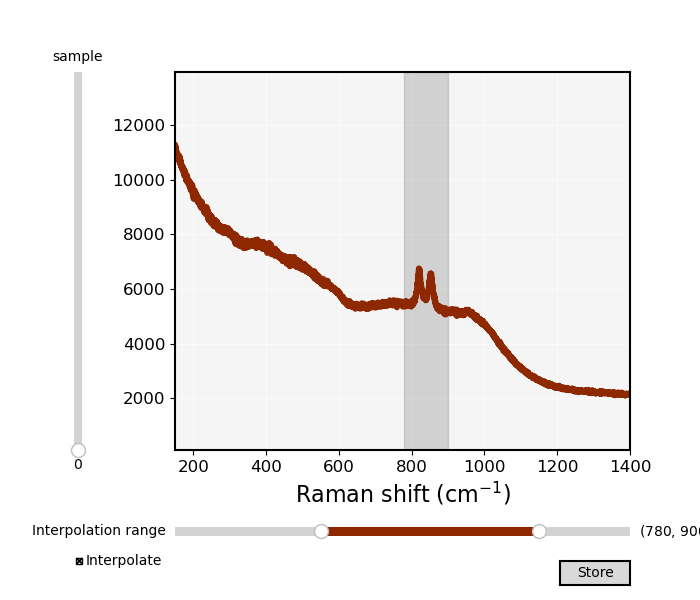

In [68]:
# Define initial parameters
init_samples = 0
init_left = samples_interpolate.loc[init_samples, "left"]
init_right = samples_interpolate.loc[init_samples, "right"]
init_interpolate = bool(samples_interpolate.loc[init_samples, "interpolate"])

%matplotlib widget

x, y = np.genfromtxt(files[0], unpack=True)

# Create the figure and the line that we will manipulate
fig, ax = plt.subplots(figsize=(7,6))
spectrum, = plt.plot(x, y)
interp_region = plt.axvspan(init_left, init_right, alpha=0.3, color="gray")

ax.set_xlabel('Raman shift (cm$^{-1})$')
ax.set_xlim(150,1400)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
ax_range = plt.axes([0.25, 0.1, 0.65, 0.03])
range_slider = w.RangeSlider(
    ax=ax_range, 
    label="Interpolation range", 
    valmin=700, 
    valmax=950, 
    valinit=(init_left, init_right),
    valstep=1
)

# Make a vertically oriented slider to control sample selection
ax_sample = plt.axes([0.1, 0.25, 0.0225, 0.63])
sample_slider = w.Slider(
    ax=ax_sample,
    label="sample",
    valmin=0,
    valmax=len(files) - 1,
    valinit=init_samples,
    valstep=1,
    orientation="vertical"
)

# Create a checkbox for interpolation
ax_interp_checkbox = plt.axes([0.1, 0.025, 0.08, 0.08], frameon=False ,aspect='equal')
interp_checkbox = w.CheckButtons(ax=ax_interp_checkbox, labels=["Interpolate"], actives=[init_interpolate])


# Create a button to store interpolation regions.
ax_store = plt.axes([0.8, 0.025, 0.1, 0.04])
button = w.Button(ax_store, 'Store', hovercolor='0.975')

# Function called when the store button is clicked
def store(event):
    idx = sample_slider.val
    left, right = range_slider.val
    samples_interpolate.loc[idx, "left"] =  left
    samples_interpolate.loc[idx, "right"] =  right
    samples_interpolate.loc[idx, "interpolate"] = interp_checkbox.get_status()[0]

# Function called when the sample slider's value changes
def update_sample(val):
    idx = int(sample_slider.val)
    x, y = np.genfromtxt(files[idx], unpack=True)
    spectrum.set_xdata(x)
    spectrum.set_ydata(y)
    range_slider.set_val((samples_interpolate.loc[idx, "left"], samples_interpolate.loc[idx, "right"]))
    if interp_checkbox.get_status()[0] ^ bool(samples_interpolate.loc[idx, "interpolate"]):
        interp_checkbox.set_active(0)
    fig.canvas.draw_idle()

# Fuction called when the range slider's values change
def update_range(val):
    left, right = *range_slider.val,
    interpolate_polygon = np.array([[left, 0.], [left, 1.], [right, 1.], [right, 0.]])
    interp_region.set_xy(interpolate_polygon)
    fig.canvas.draw_idle()

# register the update function with each slider
sample_slider.on_changed(update_sample)
range_slider.on_changed(update_range)
button.on_clicked(store)

plt.show()

In [66]:
interp_checkbox.get_status()

[True]

In [69]:
samples_interpolate

,name,interpolate,left,right
0,None,True,780,900
1,None,False,780,900
2,None,False,780,900
3,None,True,780,900
4,None,False,780,900
5,None,False,780,900
6,None,False,780,900
7,None,False,780,900
8,None,False,780,900
9,None,False,780,900
